In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 906.9 kB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.


2022-08-25 15:09:17.108664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
nltk.download?

Object `nltk.download` not found.


In [4]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('../input/nlp-getting-started/test.csv',usecols=['id','text'])
sample_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [5]:
train_data

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [6]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


# 전처리

In [7]:
train_data['text'] = train_data['text'].progress_apply(lambda x:str(x).lower())


  0%|          | 0/7613 [00:00<?, ?it/s]

In [8]:
train_data

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @thetawniest the out of control w...,1
7610,10871,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,10872,police investigating after an e-bike collided ...,1


In [9]:
th?


In [10]:
train_data['text'][6]

'#flood #disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas'

In [11]:
train_data['text'].progress_apply(lambda x: th.remove_emails(x))[6]

  0%|          | 0/7613 [00:00<?, ?it/s]

'#flood #disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas'

In [12]:
train_data['text'].progress_apply(lambda x: th.remove_html_tags(x))[6]

  0%|          | 0/7613 [00:00<?, ?it/s]

'#flood #disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas'

In [13]:
th.remove_html_tags?

In [14]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [15]:
train_clean_data = text_preprocessing(train_data, 'text')
train_clean_data

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,aria_ahrary thetawniest the out of control wil...,1
7610,10871,m194 0104 utc5km s of volcano hawaii httptcozd...,1
7611,10872,police investigating after an ebike collided w...,1


In [16]:
train_clean_data[train_clean_data.target==0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [17]:
# 카피
train_data = train_clean_data.copy()

In [18]:
train_data.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1


## wordcloud

In [19]:
print(len(stopwords.words('english')))
print(len(set(stopwords.words('english'))))

stop_words = stopwords.words('english')

179
179


In [20]:
train_data['text'].apply(lambda x : "".join([word for word in x.split() if word not in stop_words]))

0                  deedsreasonearthquakemayallahforgiveus
1                         forestfirenearlarongesaskcanada
2       residentsaskedshelterplacenotifiedofficersevac...
3       13000peoplereceivewildfiresevacuationorderscal...
4         gotsentphotorubyalaskasmokewildfirespoursschool
                              ...                        
7608    twogiantcranesholdingbridgecollapsenearbyhomes...
7609    aria_ahrarythetawniestcontrolwildfirescaliforn...
7610         m1940104utc5kmvolcanohawaiihttptcozdtoyd8ebj
7611    policeinvestigatingebikecollidedcarlittleportu...
7612    latesthomesrazednortherncaliforniawildfireabcn...
Name: text, Length: 7613, dtype: object

In [21]:
disaster_tweets = train_data[train_data.target==1]
disaster_string=[]

In [22]:
for d in disaster_tweets.text:
    disaster_string.append(d)


In [23]:
disaster_string[0]

'our deeds are the reason of this earthquake may allah forgive us all'

In [24]:
pd.Series(disaster_string).str.cat(sep='')[:100]

'our deeds are the reason of this earthquake may allah forgive us allforest fire near la ronge sask c'

In [25]:
one_disaster = pd.Series(disaster_string).str.cat(sep='')

In [26]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(one_disaster)
wordcloud

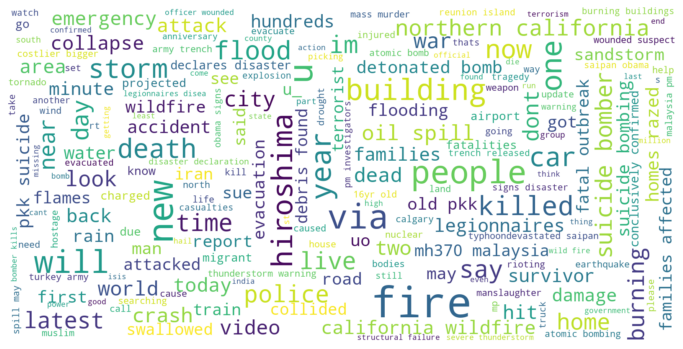

In [27]:
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

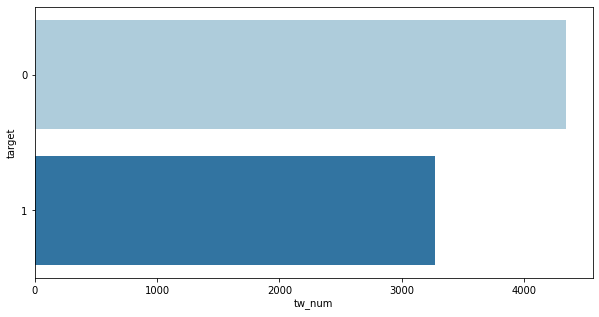

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="Paired")
plt.ylabel("target")
plt.xlabel("tw_num")
plt.show()

In [29]:
train_data

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,aria_ahrary thetawniest the out of control wil...,1
7610,10871,m194 0104 utc5km s of volcano hawaii httptcozd...,1
7611,10872,police investigating after an ebike collided w...,1


In [30]:
len(str(train_data.text[0]).split())

13

In [31]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

In [32]:
# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

In [33]:
# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [34]:
# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [35]:
# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [36]:
# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

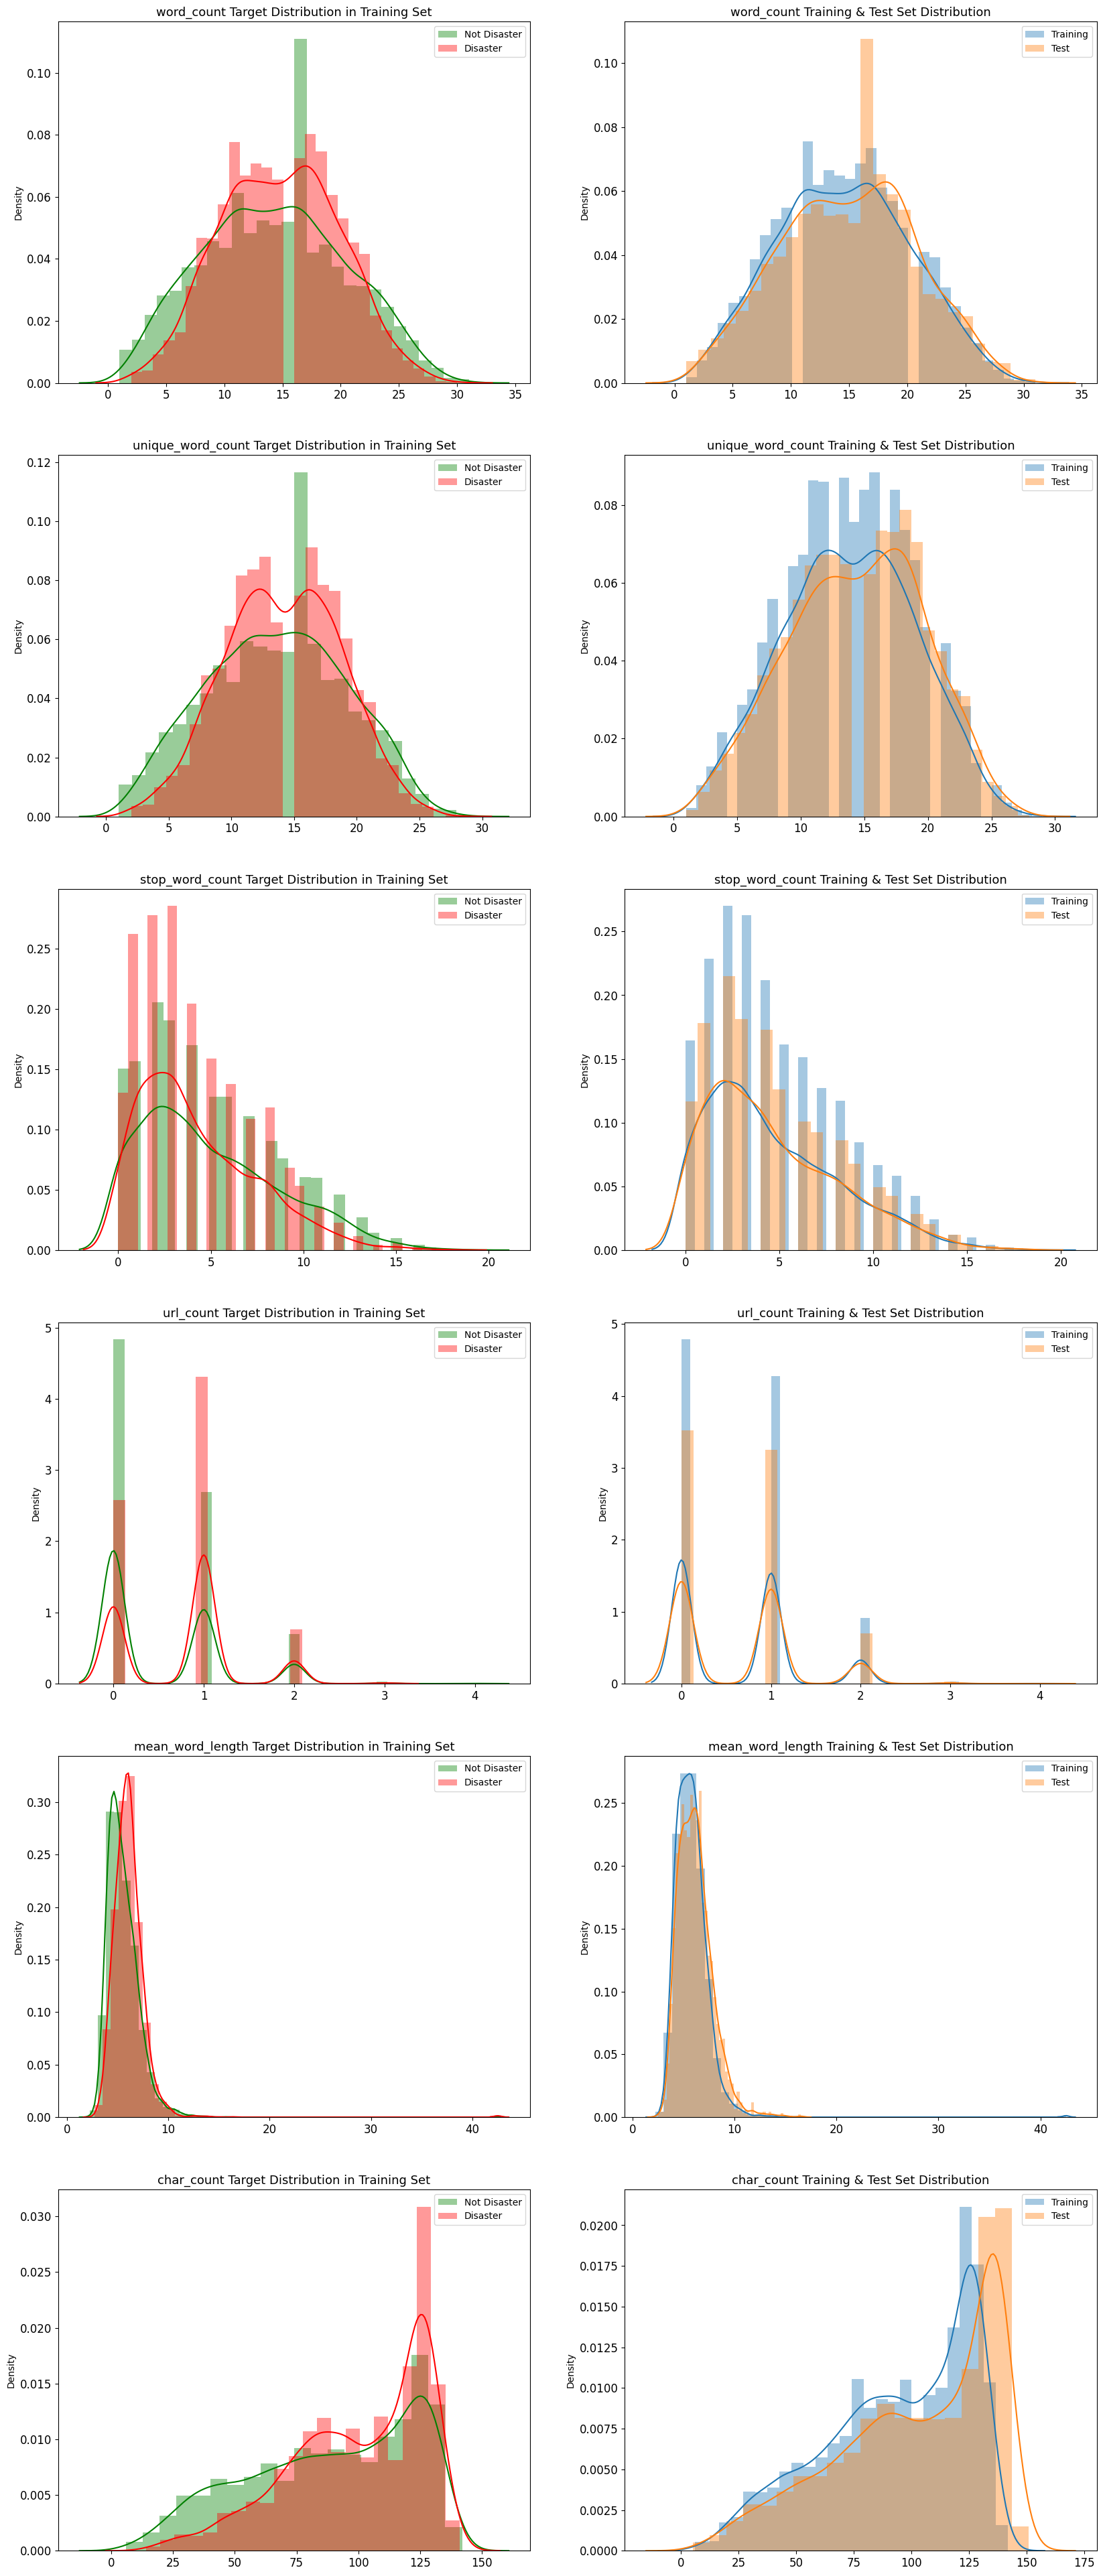

In [37]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [38]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [39]:
bert =TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [40]:
tokenizer('i am machine learning developer &*&*&&')

{'input_ids': [101, 1045, 2572, 3698, 4083, 9722, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [41]:
print("가장 긴 텍스트",max([len(x.split()) for x in train_data.text]))
max_length = 36

가장 긴 텍스트 31


In [42]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [43]:
x_train['input_ids']

<tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>

In [44]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [45]:
x_train['attention_mask']

<tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [46]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

# BERT 아키텍쳐 


In [48]:
input_ids = Input(shape=(max_len), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len), dtype=tf.int32, name = 'attention_mask')

In [49]:
input_mask

<KerasTensor: shape=(None, 36) dtype=int32 (created by layer 'attention_mask')>

In [50]:
embeddings = bert(input_ids,attention_mask = input_mask)[1]
embeddings

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'tf_bert_model')>

In [51]:
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(1,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           tf_bert_model[0][1]          

# 옵티마이져

In [53]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

In [54]:
loss = BinaryCrossentropy(from_logits = True)
loss

In [55]:
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


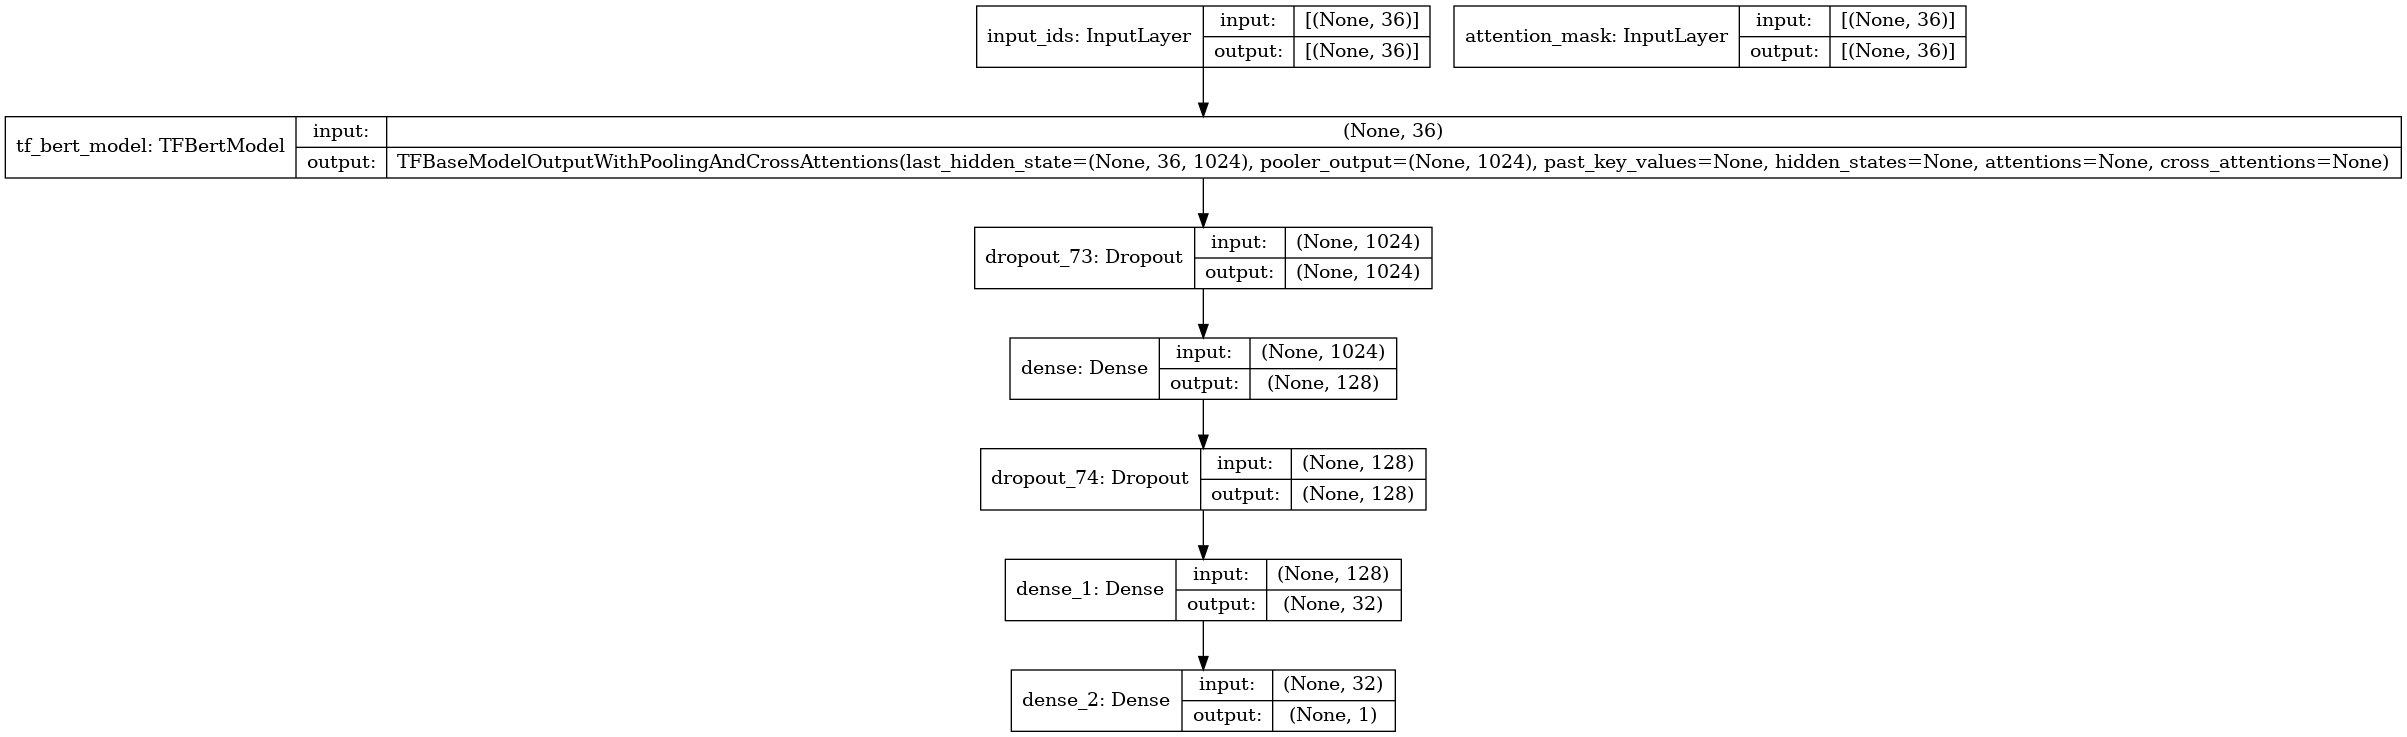

In [56]:
plot_model(model, show_shapes = True)

In [57]:
x_train

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [58]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=2,
    batch_size=32
)

2022-08-25 15:11:02.790399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
238/238 [==============================] - 5124s 21s/step - loss: 0.5636 - accuracy: 0.7293
Epoch 2/2
238/238 [==============================] - 5003s 21s/step - loss: 0.4234 - accuracy: 0.8231


# 예측

In [59]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [60]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [61]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]

In [62]:
sample_data['id'] = test_data.id
sample_data['target'] = y_predicted

In [63]:
sample_data.to_csv('submission.csv',index = False)
print(" Successfully completed! ")

 Successfully completed! 
